# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science - Final Project 


##  Team 84 - Final Project : Predicting Types of Crime

**Team Members**: Roopesh Kumar Chappidi , Shamsul Irfan Haq Mohammed, Ammaresh Venkataramappa and Sita Naga Lakshmi Pathuri<br/>


**Harvard University**<br/> 
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner<br/>
**Project Teaching Faculty**: Evan Cliff MacKay

**WebSite Link**:https://sites.google.com/g.harvard.edu/cs109a-predicting-crimes/home<br/>
**GitHub URL**:https://github.com/chroops/2019fa-cs109a-final-team84

<hr style="height:2pt">


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# importing all the necessary libraries/packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MaxNLocator

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)


from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score,roc_auc_score
from scipy.sparse import coo_matrix
import time

### Step 1: Data Loading and summary statistics

Read the crime csv file 'tmp48otqq1o.csv' from the Government of Boston’s website and save it as variable crimes_df. 
The dataset is from August 2015 till today.

https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system

This report is based on crimes reported to, and arrests made by, the Boston Police Department within the City of Boston.

Other two supporting data sets that will be used later are Property assessment and Streetlight location information.

https://data.boston.gov/dataset/property-assessment

https://data.boston.gov/dataset/streetlight-locations


In [3]:
# reading the raw crimes dataset
crimes_df = pd.read_csv('data/crime-reports/crimes.csv')

- Raw shape of dataset --> 440045 rows, 17 cols
- Inspecting the dtypes

In [4]:
crimes_df.shape
crimes_df.info()

(440045, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440045 entries, 0 to 440044
Data columns (total 17 columns):
INCIDENT_NUMBER        440045 non-null object
OFFENSE_CODE           440045 non-null int64
OFFENSE_CODE_GROUP     426840 non-null object
OFFENSE_DESCRIPTION    440045 non-null object
DISTRICT               437802 non-null object
REPORTING_AREA         440045 non-null object
SHOOTING               14952 non-null object
OCCURRED_ON_DATE       440045 non-null object
YEAR                   440045 non-null int64
MONTH                  440045 non-null int64
DAY_OF_WEEK            440045 non-null object
HOUR                   440045 non-null int64
UCR_PART               426730 non-null object
STREET                 426272 non-null object
Lat                    399636 non-null float64
Long                   399636 non-null float64
Location               440045 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 57.1+ MB


In [5]:
crimes_df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,WASHINGTON ST,NaN,NaN,"(0.00000000, 0.00000000)"
2,I90583827,1402,NaN,VANDALISM,E18,498,0,2019-11-02 05:09:00,2019,11,Saturday,5,NaN,BRADLEE ST,NaN,NaN,"(0.00000000, 0.00000000)"
3,I192082859,724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)"
4,I192082751,724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)"


#### Inspecting null values


In [6]:
# Total number of missing values
print(crimes_df.isnull().sum())

INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP      13205
OFFENSE_DESCRIPTION         0
DISTRICT                 2243
REPORTING_AREA              0
SHOOTING               425093
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                13315
STREET                  13773
Lat                     40409
Long                    40409
Location                    0
dtype: int64


- Observation 

        Looking at the SHOOTING column we obsere that lot of them have missing values - 425093

In [7]:
# find missing nan for shooting
missing_shooting = len(crimes_df[(pd.isna(crimes_df['SHOOTING']) == True)])
missing_shooting

425093

- Impute nan for SHOOTING as 0 (no shooting occured)

In [8]:
# replace nan with '0' - no shooting
# replace Y with '1' - shooting true so all are 1 instead of Y for some and 1 for some.
crimes_df['SHOOTING'].replace(np.nan, '0', inplace = True)
crimes_df['SHOOTING'].replace('Y', '1', inplace = True)
crimes_df['SHOOTING'].value_counts()

0    438187
1      1858
Name: SHOOTING, dtype: int64

#### Helper Functions for Plotting Graphs

In [9]:
def offense_groups_countplot(data, title, xlabel, ylabel, size):
    plt.figure(figsize=size)
    ax = sns.countplot(y=data['OFFENSE_CODE_GROUP'], palette='viridis', order=data['OFFENSE_CODE_GROUP'].value_counts().index)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(title, fontsize=16, fontweight='bold', pad=10)
    plt.xlabel(xlabel, weight='bold')
    plt.ylabel(ylabel, weight='bold')
    plt.tight_layout()
    plt.show()

def heatmap_plot(data, title):
    plt.figure(figsize=(10,3))
    ax = sns.heatmap(data, cmap='BuPu')
    ax.xaxis.set_ticks_position('top')
    _ = plt.xlabel('')
    _ = plt.ylabel('')
    _ = plt.title(title, fontsize=16, fontweight='bold', pad=10)
    plt.tight_layout()
    plt.show()


#### Lets visualize only when shootings occured and see which offence types are most common

In [10]:
shootings = crimes_df[~(crimes_df['SHOOTING'] == '0') ]

shootings.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
874,I192077645,413,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,B2,295,1,2019-09-26 02:38:00,2019,9,Thursday,2,Part One,DABNEY ST,42.324098,-71.084830,"(42.32409762, -71.08483043)"
875,I192077645,2662,Ballistics,BALLISTICS EVIDENCE/FOUND,B2,295,1,2019-09-26 02:38:00,2019,9,Thursday,2,Part Two,DABNEY ST,42.324098,-71.084830,"(42.32409762, -71.08483043)"
887,I192077627,413,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,C11,344,1,2019-09-25 23:42:00,2019,9,Wednesday,23,Part One,WESTVILLE TER,42.300980,-71.068699,"(42.30098009, -71.06869928)"
2439,I192075921,413,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,C6,,1,2019-09-20 21:40:00,2019,9,Friday,21,Part One,DR. MICHAEL GAVIN WAY,NaN,NaN,"(0.00000000, 0.00000000)"
2440,I192075921,1510,Firearm Violations,WEAPON - FIREARM - OTHER VIOLATION,C6,,1,2019-09-20 21:40:00,2019,9,Friday,21,Part Two,DR. MICHAEL GAVIN WAY,NaN,NaN,"(0.00000000, 0.00000000)"


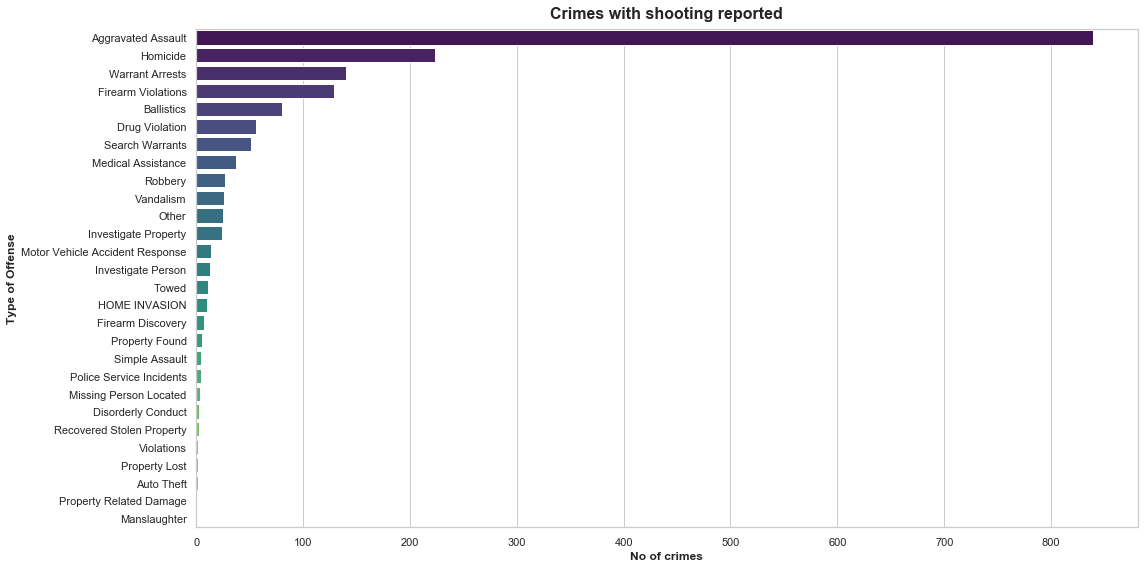

In [11]:
offense_groups_countplot(shootings, 'Crimes with shooting reported', 'No of crimes', 'Type of Offense', (16,8))

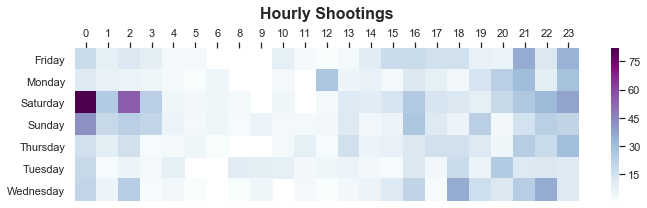

In [12]:
shootings_dow = shootings.pivot_table(index='DAY_OF_WEEK', columns='HOUR', values='INCIDENT_NUMBER', aggfunc='count')
heatmap_plot(shootings_dow, 'Hourly Shootings')

##### Observation with shooting reported:

From the heatmap, we see particularly high offences involving shooting during midnights over weekend.
Other than this callout, there doesn't seem to be any clear patterns yet when shooting is involved.

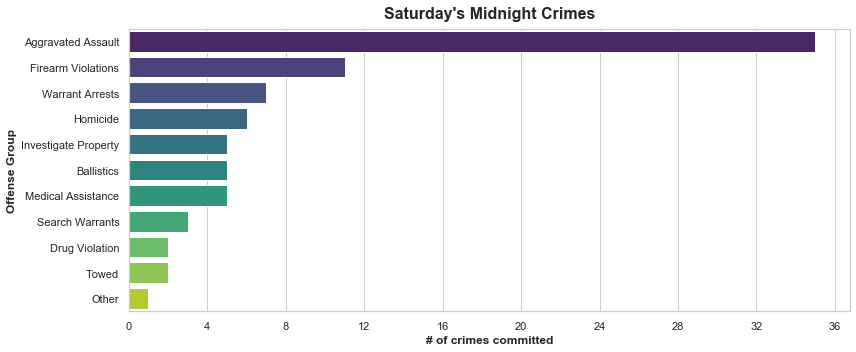

In [13]:
# only for saturday to see the types of offences

shootings_sat = shootings[shootings['DAY_OF_WEEK'].eq('Saturday') & shootings['HOUR'].eq(0)]
offense_groups_countplot(shootings_sat, "Saturday's Midnight Crimes", '# of crimes committed', 'Offense Group', (12,5))

### Looking at few more patterns with shooting involved

***Number of Shootings based on Months***

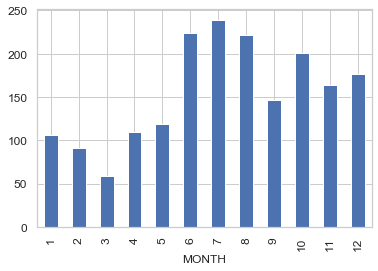

In [14]:
shootings.groupby('MONTH').size().plot(kind = 'bar',x='Month',y='Count' , fontsize=12)

***Shootings by district***

In [15]:
display(shootings['DISTRICT'].value_counts() / len(shootings))

B2     0.347686
B3     0.226050
C11    0.166846
D4     0.062971
E13    0.061895
E18    0.036060
C6     0.030678
A7     0.018837
D14    0.016146
E5     0.015070
A1     0.011841
A15    0.004844
Name: DISTRICT, dtype: float64

In [16]:
print((shootings['DISTRICT'].value_counts() / len(shootings))[:3].sum())

0.7405812701829925


#### Top 3 districts constitutes for 74 % of shooting  ---- we can do it for zip -- once we have the data

B2= 'Roxbury'     0.347686

B3= 'Mattapan'     0.226050

C11= 'Dorchester'    0.166846

district names are derived columns from another lookup dataset we created

***Shootings by Street***

In [17]:
shootings.groupby('STREET').size().sort_values(ascending = False)

STREET
WASHINGTON ST             77
BLUE HILL AVE             57
COLUMBIA RD               44
DUDLEY ST                 41
CENTRE ST                 29
CRESTON ST                23
TREMONT ST                23
COLUMBUS AVE              21
NORFOLK ST                20
ANNUNCIATION RD           19
DORCHESTER AVE            18
SCHROEDER PLZ             18
RIVER ST                  18
INTERVALE ST              16
COPELAND ST               15
MATTAPAN ST               15
MASSACHUSETTS AVE         15
GENEVA AVE                14
BRACKETT ST               14
DUDLEY TER                14
WESTVIEW ST               13
MAPLE ST                  13
MORTON ST                 13
BOWER ST                  12
NORTHAMPTON ST            12
YAWKEY WAY                12
HARRISON AVE              12
PARKER ST                 12
HUMBOLDT AVE              11
HOMESTEAD ST              11
                          ..
YORK ST                    1
CROWLEY-ROGERS WAY         1
JOHNSTON RD                1
HAMILTO

#### These streets are more frequent with shooting involved crimes.
        
        COLUMBIA RD, Washington St and BLUE HILL AVE

#### Number of Incidents each year

In [18]:
crime_yr = crimes_df.groupby('YEAR')['INCIDENT_NUMBER'].count()
crime_yr

YEAR
2015     53597
2016     99430
2017    101338
2018     98888
2019     86792
Name: INCIDENT_NUMBER, dtype: int64

Text(0.5, 0, 'YEAR')

Text(0, 0.5, 'INCIDENT COUNT')

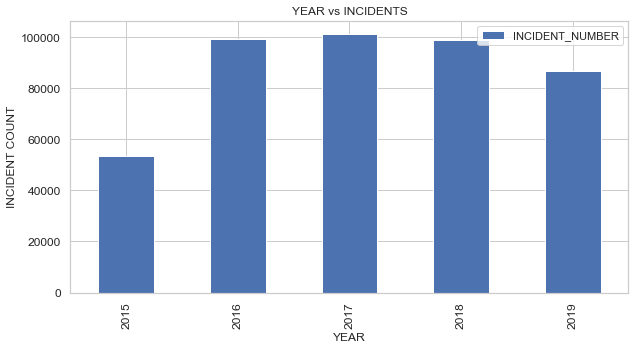

In [19]:
crime_yr = crimes_df.groupby('YEAR')['INCIDENT_NUMBER'].count()
ax = crime_yr.plot(kind='bar', title ="YEAR vs INCIDENTS",figsize=(10,5),legend=True, fontsize=12)
ax.set_xlabel("YEAR", fontsize=12)
ax.set_ylabel("INCIDENT COUNT", fontsize=12)
plt.show()

#### Heat map to visualize incidents by hour

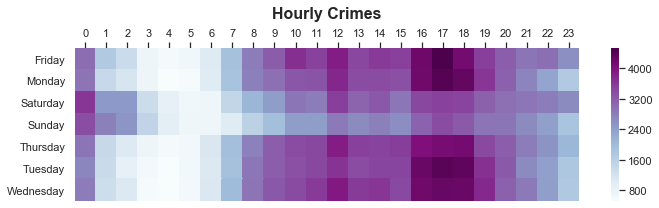

In [20]:
crimes_dow_hour = crimes_df.pivot_table(index='DAY_OF_WEEK', columns='HOUR', values='INCIDENT_NUMBER', aggfunc='count')
heatmap_plot(crimes_dow_hour, 'Hourly Crimes')

##### Observations

- We can see lot of incidents around evening time between 4 PM  to 7 PM. 

- Less incident timezones are between 1 AM to 8 AM. 

- But from Midnight to 1 AM seems prone to more crimes.

- On weekends, the patterns shows the crimes are ongoing saga untill late night. As more people are partying and outside?.

#### Column UCR_PART

The column UCR_PART does have a relation with the stages of an incident and we tried using it with a bit of cleaning initially, but due lack of proper data tagged with each incident we went ahead only considering Part One for addressing duplicate incidents.

In [21]:
crimes_df['UCR_PART'] = crimes_df['UCR_PART'].fillna('Other')

In [22]:
# we observered duplicate incidents as well in the data set
dup_crimes = crimes_df.pivot_table(index=['INCIDENT_NUMBER'], aggfunc='size')
print (dup_crimes[dup_crimes>1])

INCIDENT_NUMBER
I030217815-08     2
I060168073-00     3
I070720870-00    11
I080542626-00     4
I090317057-00     2
I090321958-00     2
I100033064-00     3
I100340225-00     5
I100636670-00     3
I110177502-00     5
I110261417-00     3
I110372326-00     3
I110551302-00     2
I110694557-00     5
I120069826-00     3
I120189428-00     4
I120201612-00     7
I120283195-00     3
I120470733-00     4
I120595668-00     3
I120719309-00     6
I120720047-00     5
I130031413-00     5
I130041200-00    13
I130084703-00     2
I130126035-00     5
I130194606-00    11
I130202615-00     5
I130204032-00     6
I130304171-00     2
                 ..
I192078170        2
I192078174        2
I192078193        2
I192078201        2
I192078240        2
I192078245        3
I192078263        5
I192078297        2
I192078316        2
I192078319        2
I192078324        2
I192078354        3
I192078381        2
I192078461        2
I192078482        2
I192078484        2
I192078496        2
I192078520        2
I192

In [23]:
crimes_df[crimes_df.INCIDENT_NUMBER=='I070720870-00']

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
427238,I070720870-00,3125,Warrant Arrests,WARRANT ARREST,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
427239,I070720870-00,3125,Warrant Arrests,WARRANT ARREST,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
427240,I070720870-00,637,Larceny,LARCENY IN A BUILDING UNDER $50,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part One,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
427241,I070720870-00,637,Larceny,LARCENY IN A BUILDING UNDER $50,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part One,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
427242,I070720870-00,637,Larceny,LARCENY IN A BUILDING UNDER $50,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part One,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
427243,I070720870-00,3125,Warrant Arrests,WARRANT ARREST,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
427244,I070720870-00,3125,Warrant Arrests,WARRANT ARREST,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
427245,I070720870-00,3125,Warrant Arrests,WARRANT ARREST,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
427246,I070720870-00,802,Simple Assault,ASSAULT & BATTERY,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Two,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
427247,I070720870-00,802,Simple Assault,ASSAULT & BATTERY,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Two,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"


#### Cleaning up the duplicate incident rows

In [24]:
crimes_final=crimes_df.drop_duplicates(subset='INCIDENT_NUMBER', keep="first")

In [25]:
print(crimes_df.shape)
print('\nNumber of rows,columns after removing Duplicated incident rows\n',crimes_final.shape)

(440045, 17)

Number of rows,columns after removing Duplicated incident rows
 (388802, 17)


In [26]:
# checking for duplicate incidents
dup_crimes_final = crimes_final.pivot_table(index=['INCIDENT_NUMBER'], aggfunc='size')
print (dup_crimes_final[dup_crimes_final>1])

# There are no duplicates on Incident number at this step

Series([], dtype: int64)


#### Analysis on types of Offense code groups

In [27]:
crimes_final['OFFENSE_CODE_GROUP'].unique()
crimes_final['OFFENSE_CODE_GROUP'].nunique()

# replacing NANs with a filler value NotExists
crimes_final['OFFENSE_CODE_GROUP'] = crimes_final['OFFENSE_CODE_GROUP'].replace(np.nan, 'NotExists')

array([nan, 'Auto Theft', 'Investigate Property', 'Investigate Person',
       'Vandalism', 'Motor Vehicle Accident Response',
       'Residential Burglary', 'Verbal Disputes', 'Larceny',
       'Firearm Violations', 'Medical Assistance', 'Aggravated Assault',
       'Missing Person Reported', 'Robbery', 'Simple Assault',
       'Property Lost', 'Violations', 'Warrant Arrests', 'Ballistics',
       'Towed', 'Drug Violation', 'Fire Related Reports', 'Other',
       'Disorderly Conduct', 'Larceny From Motor Vehicle',
       'Police Service Incidents', 'Missing Person Located', 'Harassment',
       'Property Found', 'Liquor Violation', 'Property Related Damage',
       'Fraud', 'Confidence Games', 'Commercial Burglary',
       'Recovered Stolen Property', 'Other Burglary',
       'Assembly or Gathering Violations', 'Counterfeiting',
       'Prisoner Related Incidents', 'License Plate Related Incidents',
       'Restraining Order Violations', 'Search Warrants',
       'License Violation', 

65

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [28]:
crimes_final.groupby(['OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION']).size()

OFFENSE_CODE_GROUP                OFFENSE_DESCRIPTION                                       
Aggravated Assault                ASSAULT & BATTERY D/W - OTHER                                     1
                                  ASSAULT - AGGRAVATED                                           2830
                                  ASSAULT - AGGRAVATED - BATTERY                                 5345
                                  ASSAULT D/W - KNIFE ON POLICE OFFICER                             1
                                  ASSAULT D/W - OTHER                                               1
Aircraft                          AIRCRAFT INCIDENTS                                               60
Arson                             ARSON                                                            87
Assembly or Gathering Violations  DEMONSTRATIONS/RIOT                                             336
                                  GATHERING CAUSING ANNOYANCE                              

#### New categorization for the Offense types

We have created a look-up for the Crime Type Data based on the Offense Description and Code columns and general definition of each offense type

Categorized the crimes to primarily four different Categories as follows:

    Personal Crimes
    ['Assault','Battery','False Imprisonment','Kidnapping','Homicide','first and second degree murder','manslaughter','vehicular homicide','Rape','statutory rape','sexual assault']

    Property Crimes
    ['Larceny','Robbery','Theft','Burglary','Arson','Embezzlement','Forgery','False pretenses','Receipt of stolen goods']

    Statutory Crimes
    ['drunk driving','Alcohol','Selling alcohol to a minor']
    
    Inchoate Crimes
    ['Attempt','Solicitation','Conspiracy']
    
reference url - https://www.legalmatch.com/law-library/article/what-are-the-different-types-of-crimes.html

The cleaned by data (DimGroupsFinal.csv) is loaded as dimension groups to use with Crime dataframe. 

In [29]:
#Y => Aggregated groups bucketing
dim_grps=pd.read_csv('data/crime-reports/DimGroupsFinal.csv')
dim_grps=dim_grps[['OFFENSE_DESCRIPTION', 'Crime_sub_Type']]

In [30]:
crimes_tmp=pd.merge(crimes_final,dim_grps,on='OFFENSE_DESCRIPTION',how='left')

In [31]:
#crimes_final.shape
print('\nNumber of rows,columns with new Crime Type \n',crimes_tmp.shape)
#dim_grps.shape


Number of rows,columns with new Crime Type 
 (388802, 18)


#### Some more patters with District vs Incidents

Decoding the district code to distict names for EDA

District Names is found from the police department URL: https://bpdnews.com/districts

Just from the district codes is hard to know where the crime was reported in Boston, so we have decoded the district code to District name, so we can perform the EDA on the distict name and see if district has any effect on crime or type of crime

In [32]:
#List unique values in the df['name'] column
crimes_tmp.DISTRICT.unique()

array(['External', 'E13', 'E18', 'D14', 'D4', 'A15', 'B3', 'A1', 'A7',
       'E5', 'B2', 'C11', 'C6', nan], dtype=object)

In [33]:
# Create the dictionary 
DISTRICT_NAME ={'External' : 'External', 'A1' : 'Downtown', 'A15': 'Charlestown', 
                'A7': 'East Boston', 'B2': 'Roxbury', 'B3': 'Mattapan',
                'C6': 'South Boston','C11': 'Dorchester','D4': 'South End','D14': 'Brighton',
                'E5': 'West Roxbury','E13':'Jamaica Plain','E18': 'Hyde Park'}

crimes_tmp['DISTRICT_NAME'] = crimes_tmp['DISTRICT'].map(DISTRICT_NAME)     


In [34]:
# Print the DataFrame 
crimes_tmp.DISTRICT_NAME.unique()
crimes_tmp['DISTRICT_NAME'] = crimes_tmp['DISTRICT_NAME'].replace(np.nan, 'NotExists')
crimes_tmp.head()
crimes_tmp.shape

array(['External', 'Jamaica Plain', 'Hyde Park', 'Brighton', 'South End',
       'Charlestown', 'Mattapan', 'Downtown', 'East Boston',
       'West Roxbury', 'Roxbury', 'Dorchester', 'South Boston', nan],
      dtype=object)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,Crime_sub_Type,DISTRICT_NAME
0,TESTTEST2,423,NotExists,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,Other,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)",PersonalCrime,External
1,I92089785,3005,NotExists,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,Other,WASHINGTON ST,NaN,NaN,"(0.00000000, 0.00000000)",PersonalCrime,Jamaica Plain
2,I90583827,1402,NotExists,VANDALISM,E18,498,0,2019-11-02 05:09:00,2019,11,Saturday,5,Other,BRADLEE ST,NaN,NaN,"(0.00000000, 0.00000000)",PropertyCrime,Hyde Park
3,I192082859,724,Auto Theft,AUTO THEFT,E18,519,0,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)",PropertyCrime,Hyde Park
4,I192082751,724,Auto Theft,AUTO THEFT,E18,493,0,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)",PropertyCrime,Hyde Park


(388802, 19)

In [35]:
crimes_tmp.DISTRICT_NAME.unique()

array(['External', 'Jamaica Plain', 'Hyde Park', 'Brighton', 'South End',
       'Charlestown', 'Mattapan', 'Downtown', 'East Boston',
       'West Roxbury', 'Roxbury', 'Dorchester', 'South Boston',
       'NotExists'], dtype=object)

In [36]:
crimes_tmp.OFFENSE_CODE_GROUP.value_counts().nlargest(30)

Motor Vehicle Accident Response    47864
Medical Assistance                 31985
Larceny                            31902
Investigate Person                 24002
Other                              19510
Vandalism                          18323
Simple Assault                     17523
Verbal Disputes                    17214
Drug Violation                     14841
Investigate Property               14771
Towed                              14340
NotExists                          13205
Property Lost                      13182
Larceny From Motor Vehicle         12746
Aggravated Assault                  8178
Fraud                               7869
Warrant Arrests                     6440
Residential Burglary                6228
Missing Person Located              5659
Violations                          5412
Harassment                          5243
Property Found                      5088
Auto Theft                          5068
Robbery                             4806
Police Service I

In [37]:
# picking five types of crimes and analyzing those

#Larcency
#Vandalism
#Fraud
#Auto Theft
#Robbery
crimes5_df = crimes_tmp[crimes_tmp['OFFENSE_CODE_GROUP'].isin(['Larceny', 'Vandalism','Fraud','Auto Theft','Robbery']) ]
crimes5_df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,Crime_sub_Type,DISTRICT_NAME
3,I192082859,724,Auto Theft,AUTO THEFT,E18,519,0,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)",PropertyCrime,Hyde Park
4,I192082751,724,Auto Theft,AUTO THEFT,E18,493,0,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)",PropertyCrime,Hyde Park
5,I192082680,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,D14,794,0,2019-10-12 15:12:43,2019,10,Saturday,15,Part One,ALLSTON ST,42.352375,-71.135096,"(42.35237455, -71.13509584)",PropertyCrime,Brighton
6,I192082577,724,Auto Theft,AUTO THEFT,D4,130,0,2019-10-12 04:41:52,2019,10,Saturday,4,Part One,SAINT JAMES AVE,42.349476,-71.076402,"(42.34947586, -71.07640150)",PropertyCrime,South End
7,I192079582,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,A15,47,0,2019-10-02 08:08:49,2019,10,Wednesday,8,Part One,N MEAD ST,42.381846,-71.066551,"(42.38184582, -71.06655134)",PropertyCrime,Charlestown


In [38]:
# By Month the five crime Types in year 2019
crimes5_df[crimes5_df.YEAR==2019].groupby(['OFFENSE_CODE_GROUP','MONTH']).size().unstack(0)

OFFENSE_CODE_GROUP,Auto Theft,Fraud,Larceny,Robbery,Vandalism
MONTH,,,,,
1,63.0,188.0,538.0,63.0,299.0
2,53.0,190.0,482.0,50.0,231.0
3,60.0,173.0,528.0,44.0,339.0
4,72.0,176.0,538.0,53.0,294.0
5,78.0,166.0,610.0,70.0,330.0
6,98.0,143.0,638.0,73.0,294.0
7,115.0,190.0,680.0,87.0,351.0
8,126.0,148.0,738.0,86.0,416.0
9,106.0,130.0,622.0,76.0,333.0


In [39]:
crimes5_df[crimes5_df.YEAR==2019].groupby(['OFFENSE_CODE_GROUP','DAY_OF_WEEK']).size().unstack(0)

OFFENSE_CODE_GROUP,Auto Theft,Fraud,Larceny,Robbery,Vandalism
DAY_OF_WEEK,,,,,
Friday,104,289,870,78,403
Monday,110,245,747,82,435
Saturday,112,121,778,93,462
Sunday,106,87,630,99,426
Thursday,116,234,757,81,375
Tuesday,123,244,764,77,407
Wednesday,105,284,828,92,379


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000132A8F952E8>,
      dtype=object)

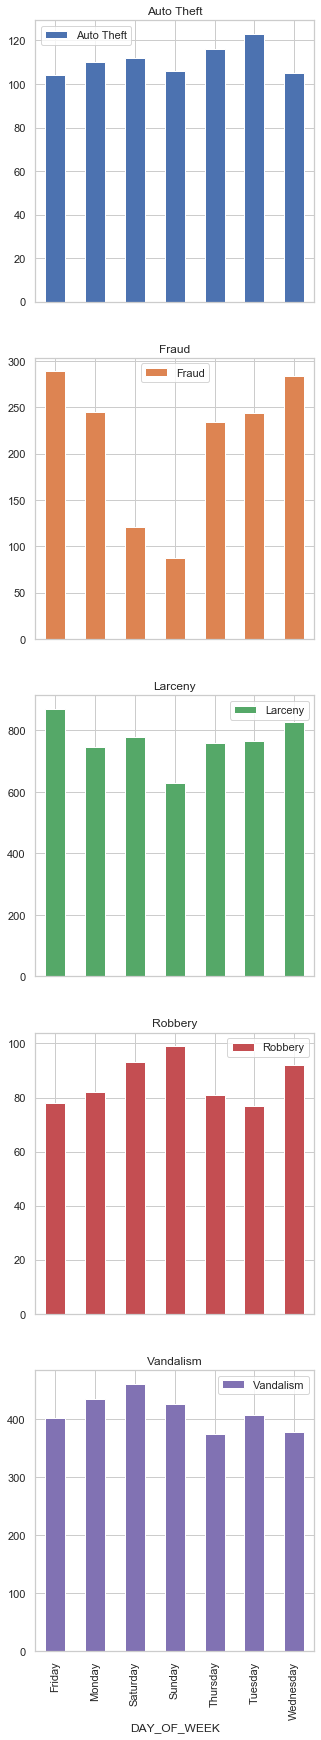

In [40]:
crimes5_df[crimes5_df.YEAR==2019].groupby(['OFFENSE_CODE_GROUP','DAY_OF_WEEK']).size().unstack(0).plot(subplots=True, kind='bar', figsize = (5, 30))

In [41]:
# Top 10 crime reported streets In these 5 categories
streets = crimes5_df.groupby([crimes5_df['STREET'].fillna('NO STREET NAME')])['REPORTING_AREA'].aggregate(np.size).reset_index().sort_values('REPORTING_AREA',ascending = False).head(10)
streets

,STREET,REPORTING_AREA
3109,WASHINGTON ST,3687
370,BOYLSTON ST,3142
331,BLUE HILL AVE,1400
2957,TREMONT ST,1271
2165,NEWBURY ST,1271
1572,HUNTINGTON AVE,1250
905,DORCHESTER AVE,1120
1939,MASSACHUSETTS AVE,1101
698,COMMONWEALTH AVE,1064
1410,HARRISON AVE,1024


[Text(0, 0, 'WASHINGTON ST'),
 Text(0, 0, 'BOYLSTON ST'),
 Text(0, 0, 'BLUE HILL AVE'),
 Text(0, 0, 'TREMONT ST'),
 Text(0, 0, 'NEWBURY ST'),
 Text(0, 0, 'HUNTINGTON AVE'),
 Text(0, 0, 'DORCHESTER AVE'),
 Text(0, 0, 'MASSACHUSETTS AVE'),
 Text(0, 0, 'COMMONWEALTH AVE'),
 Text(0, 0, 'HARRISON AVE')]

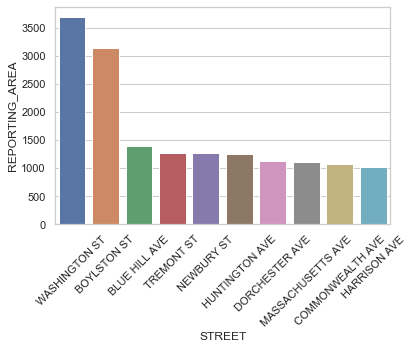

In [42]:
chart=sns.barplot(x="STREET", y="REPORTING_AREA", data = streets)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

#### Observations on specific crime types

Considering the 5 crime types - 'Larceny', 'Vandalism','Fraud','Auto Theft','Robbery'

We can see that WASHINGTON ST and BOYLSTON ST are the most incident prone streets.

WASHINGTON ST is a high propensity crime street

Robbery is high and Larceny is low on Sunday

Fraud type of crimes are common on weekdays

Auto theft and vandalism are spread across irrespective of day.

#### Finalizing the columns to use

In [43]:
crimes_final_df= crimes_tmp.copy()
crimes_final_df = crimes_final_df.drop(['INCIDENT_NUMBER','OFFENSE_CODE','OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT','UCR_PART','Location'], axis=1)
rename = {'REPORTING_AREA':'Area',
         'SHOOTING':'Shooting',
         'OCCURRED_ON_DATE':'Date',
         'YEAR':'Year',
         'MONTH':'Month',
         'DAY_OF_WEEK':'Day',
         'HOUR':'Hour',
         'STREET':'Street',
         'Lat':'Latitude',
         'Long':'Longitude',
         'Crime_sub_Type':'CrimeType',
         'DISTRICT_NAME':'DistrictName'}

crimes_final_df.rename(index=str, columns=rename, inplace=True)

#### Cleaning  NANs/NULL's in shooting and street columns

In [44]:
print(crimes_final_df.isnull().sum())
crimes_final_df.Shooting.unique()

crimes_final_df['Shooting'].fillna('0', inplace=True)
crimes_final_df.Shooting.unique()

crimes_final_df['Street'].fillna('Unknown', inplace=True)
crimes_final_df.Street.unique()

print(crimes_final_df.isnull().sum())

Area                0
Shooting            0
Date                0
Year                0
Month               0
Day                 0
Hour                0
Street          11803
Latitude        36442
Longitude       36442
CrimeType           0
DistrictName        0
dtype: int64


array(['0', '1'], dtype=object)

array(['0', '1'], dtype=object)

array(['RIVERVIEW DR', 'WASHINGTON ST', 'BRADLEE ST', ..., 'POND',
       'JERSEY STREET  BOSTON  MA  USA', '1ST AVE'], dtype=object)

Area                0
Shooting            0
Date                0
Year                0
Month               0
Day                 0
Hour                0
Street              0
Latitude        36442
Longitude       36442
CrimeType           0
DistrictName        0
dtype: int64


In [45]:
#FINAL TABLE FOR VISUALIZATION AND ANALYSIS
crimes_final_df.head()
#CrimeType is Ylabel and others can be analyzed and used as predictors after converting them to categorical columns


,Area,Shooting,Date,Year,Month,Day,Hour,Street,Latitude,Longitude,CrimeType,DistrictName
0,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,RIVERVIEW DR,NaN,NaN,PersonalCrime,External
1,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,WASHINGTON ST,NaN,NaN,PersonalCrime,Jamaica Plain
2,498,0,2019-11-02 05:09:00,2019,11,Saturday,5,BRADLEE ST,NaN,NaN,PropertyCrime,Hyde Park
3,519,0,2019-10-13 09:28:24,2019,10,Sunday,9,LINCOLN ST,42.259518,-71.121563,PropertyCrime,Hyde Park
4,493,0,2019-10-12 20:11:26,2019,10,Saturday,20,METROPOLITAN AVE,42.262092,-71.116710,PropertyCrime,Hyde Park


In [46]:
# Check (4 crime Type categories)
crimes_final_df['CrimeType'].value_counts()

PersonalCrime      174262
PropertyCrime      158806
IncohateCrime       32084
StatutoryCrimes     23650
Name: CrimeType, dtype: int64

In [47]:
# crimes_final_df.Shooting.unique()
# crimes_final_df.Year.unique()
# crimes_final_df.Month.unique()
# crimes_final_df.Day.unique()
# crimes_final_df.DistrictName.unique()

### Distribution of Incidents wrt new Crime Type

In [48]:
def offense_groups_countplot_final(data, title, xlabel, ylabel, size):
    plt.figure(figsize=size)
    ax = sns.countplot(y=data['CrimeType'], palette='viridis', order=data['CrimeType'].value_counts().index)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(title, fontsize=16, fontweight='bold', pad=10)
    plt.xlabel(xlabel, weight='bold')
    plt.ylabel(ylabel, weight='bold')
    plt.tight_layout()
    plt.show()


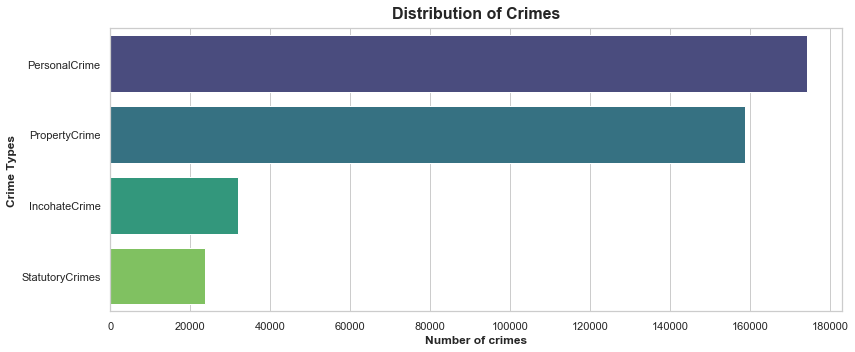

In [49]:
offense_groups_countplot_final(crimes_final_df, 'Distribution of Crimes', 'Number of crimes', 'Crime Types', (12,5))

### Baseline model with Logistic Regression CV

In [50]:
crimes_final_df_temp = crimes_final_df[crimes_final_df.columns.difference(['Date','Latitude','Longitude','Street'])]

In [51]:
crimes_final_df_temp['Area'] = pd.to_numeric(crimes_final_df_temp['Area'], errors='coerce')
crimes_final_df_temp['Area']=crimes_final_df_temp['Area'].fillna(0) 

crimes_final_df_temp['Day'] = crimes_final_df_temp['Day'].map({'Tuesday':2,'Saturday':6,'Monday':1,'Sunday':7,
                                                               'Thursday':4,'Wednesday':3,'Friday':5})

crimes_final_df_temp['DistrictName'] = crimes_final_df_temp['DistrictName'].map({'External':1, 'Jamaica Plain':2, 'Hyde Park':3, 'Brighton':4, 'South End':5,'Charlestown':6,
     'Mattapan':7, 'Downtown':8, 'East Boston':9,'West Roxbury':10, 'Roxbury':11, 'Dorchester':12, 'South Boston':13,
     'NotExists':14})

crimes_final_df_temp.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

,Area,CrimeType,Day,DistrictName,Hour,Month,Shooting,Year
0,0.0,PersonalCrime,3,1,0,10,0,2019
1,574.0,PersonalCrime,2,2,18,11,0,2019
2,498.0,PropertyCrime,6,3,5,11,0,2019
3,519.0,PropertyCrime,7,3,9,10,0,2019
4,493.0,PropertyCrime,6,3,20,10,0,2019


#### Preparing the dataframes to feed the model

In [52]:
#excluding the response column CrimeType
crimes_final_df_X = crimes_final_df_temp[crimes_final_df_temp.columns.difference(['CrimeType'])]
crimes_final_df_Y=pd.DataFrame()
crimes_final_df_Y['CrimeType']= crimes_final_df_temp['CrimeType']

# Change the crimetype as categorical value 1,2,3,4
crimes_final_df_Y['CrimeType'] = crimes_final_df_Y['CrimeType'].map({'PersonalCrime':1, 'PropertyCrime':2, 'StatutoryCrimes':3,
     'IncohateCrime':4})

print(crimes_final_df_Y.shape)

(388802, 1)


In [53]:
X_train,X_test,y_train,y_test=train_test_split(crimes_final_df_X,crimes_final_df_Y, test_size=0.2, random_state=90)

In [54]:
# build logistic regression cv model
Cs = 10.0**np.arange(-5,5)
logregCV_mc = LogisticRegressionCV(Cs = Cs,cv=5,solver='lbfgs',multi_class='multinomial')
logregCV_mc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [55]:
# predict on train and test sets using the model
y_train_pred_multi = logregCV_mc.predict(X_train) 
y_test_pred_multi = logregCV_mc.predict(X_test)

# accuracy
train_score_multi = accuracy_score(y_train, y_train_pred_multi)
test_score_multi = accuracy_score(y_test,y_test_pred_multi)

print("train accuracy score:",train_score_multi)
print("test accuracy score:",test_score_multi)

train accuracy score: 0.4641928234541427
test accuracy score: 0.46563187201810674


### Applying Normalization to the columns

In [56]:
# capture results for all the models
names = []
acc_scores = []

In [57]:
mmscale=MinMaxScaler(feature_range=(0,1))
X_train_norm_df=pd.DataFrame(mmscale.fit_transform(X_train),columns=list(X_train.columns),index=X_train.index)
X_test_norm_df=pd.DataFrame(mmscale.transform(X_test),columns=list(X_test.columns),index=X_test.index)

In [58]:
Cs = 10.0**np.arange(-5,5)
logregCV_mc = LogisticRegressionCV(Cs = Cs,cv=5,solver='lbfgs',multi_class='multinomial') #l1 is Lasso like
logregCV_mc.fit(X_train_norm_df, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [59]:
y_train_pred_multi = logregCV_mc.predict(X_train_norm_df) 

y_test_pred_multi = logregCV_mc.predict(X_test_norm_df)

# accuracy
train_score_multi = accuracy_score(y_train, y_train_pred_multi)
test_score_multi = accuracy_score(y_test,y_test_pred_multi)

print("train accuracy score:",train_score_multi)
print("test accuracy score:",test_score_multi)

train accuracy score: 0.4638359573175241
test accuracy score: 0.4652975141780584


In [60]:
names.append('Logistic Regression w/ CV')
acc_scores.append([train_score_multi, test_score_multi])
df_results = pd.DataFrame(acc_scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_results.index.name = 'Model'
df_results

,Train Accuracy,Test Accuracy
Model,,
Logistic Regression w/ CV,0.463836,0.465298


In [61]:
y_test_pred_multi = logregCV_mc.predict(X_test_norm_df[:1])
print('\nPredicted class :',y_test_pred_multi)


Predicted class : [2]


In [62]:
# looking at the actual test data from that row
print(X_test[:1])
print('\nActual crime type class :',y_test[:1])

y_test_pred_multi = logregCV_mc.predict_proba(X_test_norm_df[:1])
print('\nPredicted probability for each class :',y_test_pred_multi)

print('\nActual raw incident row\n')
crimes_final_df.iloc[32257]

         Area  Day  DistrictName  Hour  Month Shooting  Year
200536  272.0    1             5    19      6        0  2017

Actual crime type class :         CrimeType
200536          1

Predicted probability for each class : [[0.42628531 0.4265941  0.07049586 0.07662473]]

Actual raw incident row



Area                            959
Shooting                          0
Date            2019-05-26 21:11:00
Year                           2019
Month                             5
Day                          Sunday
Hour                             21
Street               DORCHESTER AVE
Latitude                    42.2862
Longitude                  -71.0642
CrimeType             PersonalCrime
DistrictName             Dorchester
Name: 32257, dtype: object

### Next Steps

- Extract information from Property values and Streetlights datasets
       - We have two options finalized for this to join as we have non matching geo spatial data,
           Using Live_Street_Address_Management_SAM_Addresses.csv, we have association with street, lat, long, zip.
           Using geocode api to convert lat,long to find the zip
           Join the datasets on the zipcode, so we can get observations by zip codes.
- Categorize the area based on the Property values - (high/median/low)
- Categorize the area on number of lights - (well-lit/poorly-lit)
- Merge with Crimes dataset, and model it to classify the types of crimes.

### Analyzing property assesment files

In [63]:
pa_2019_df = pd.read_csv('data/property-assessment/property-assessment-fy2019.csv')
pa_2018_df = pd.read_csv('data/property-assessment/property-assessment-fy2018.csv')
pa_2017_df = pd.read_csv('data/property-assessment/property-assessment-fy2017.csv')
pa_2016_df = pd.read_csv('data/property-assessment/property-assessment-fy2016.csv')
pa_2015_df = pd.read_csv('data/property-assessment/property-assessment-fy2015.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (15,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (15,60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
pa_2019_df['ZIPCODE'].isna().sum()

7

In [65]:
pa_2019_df=pa_2019_df.dropna(subset=['ZIPCODE'])
pa_2018_df=pa_2018_df.dropna(subset=['ZIPCODE'])
pa_2017_df=pa_2017_df.dropna(subset=['ZIPCODE'])
pa_2016_df=pa_2016_df.dropna(subset=['ZIPCODE'])
pa_2015_df=pa_2015_df.dropna(subset=['ZIPCODE'])


In [66]:
pa_2015_df.head()

,PID,CM_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,full_address,PTYPE,LU,OWN_OCC,OWNER,OWNER_MAIL_ADDRESS,OWNER_MAIL_CS,OWNER_MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,GROSS_AREA,LIVING_AREA,NUM_FLOORS,STRUCTURE_CLASS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS,R_FULL_BTH,R_HALF_BTH,R_KITCH,R_HEAT_TYP,R_AC,R_FPLACE,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_UNIT_COM,S_UNIT_RC,S_EXT_FIN,U_BASE_FLOOR,U_NUM_PARK,U_CORNER,U_ORIENT,U_TOT_RMS,U_BDRMS,U_FULL_BTH,U_HALF_BTH,U_KIT_TYPE,U_HEAT_TYP,U_AC,U_FPLACE,Location
0,1302299000_,NaN,199,SAVIN HILL,AV,NaN,02125_,199 SAVIN HILL AV,105,R3,Y,CLAIRE M CRONIN BE,199 SAVIN HILL AVE,DORCHESTER MA,02125_,235000,344400,579400,7016,12744.0,1900.0,0.0,4454.0,3562.0,2.0,R,CV,H,M,11.0,5.0,3.0,0.0,3.0,W,N,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(42.308250000| -71.049200000)
1,1302298000_,NaN,195,SAVIN HILL,AV,NaN,02125_,195 SAVIN HILL AV,104,R2,N,MURPHY PAUL,195 SAVIN HILL AVE,DORCHESTER MA,02125_,149400,354300,503700,6099,4726.0,1925.0,2012.0,5492.0,3166.0,2.0,R,CV,H,W,14.0,6.0,3.0,0.0,2.0,W,N,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(42.308490000| -71.049460000)
2,1302297000_,NaN,193,SAVIN HILL,AV,NaN,02125_,193 SAVIN HILL AV,104,R2,Y,SZKOLKA MARCIA R,193 SAVIN HILL AVE,DORCHESTER MA,02125_,141000,304800,445800,5398,3763.0,1925.0,0.0,5648.0,3317.0,2.0,R,CV,H,W,13.0,6.0,3.0,0.0,2.0,W,N,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(42.308470000| -71.049700000)
3,1302296000_,NaN,6 8,SOUTHVIEW,ST,NaN,02125_,6 8 SOUTHVIEW ST,104,R2,Y,DAVIS KURT E,6 SOUTHVIEW ST,DORCHESTER MA,02125_,133100,300900,434000,5255,3367.0,1930.0,0.0,5426.0,3074.0,2.0,R,CV,H,M,12.0,5.0,3.0,0.0,2.0,W,N,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(42.308250000| -71.049880000)
4,1302295000_,NaN,10 12,SOUTHVIEW,ST,NaN,02125_,10 12 SOUTHVIEW ST,104,R2,Y,CIULLA MICHAEL A,10 SOUTHVIEW ST,DORCHESTER MA,02125_,140000,269500,409500,4959,3690.0,1920.0,0.0,4092.0,2536.0,2.0,R,TF,H,W,12.0,4.0,2.0,0.0,2.0,W,N,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(42.308240000| -71.049710000)


In [67]:
# ZIPCODE to 5 characters
pa_2019_df['ZIPCODE'] = '0' + pa_2019_df['ZIPCODE'].astype(str)
pa_2019_df['ZIPCODE']= pa_2019_df['ZIPCODE'].astype(str).map(lambda x: str(x)[:5])
pa_2018_df['ZIPCODE'] = '0' + pa_2018_df['ZIPCODE'].astype(str)
pa_2018_df['ZIPCODE']= pa_2018_df['ZIPCODE'].astype(str).map(lambda x: str(x)[:5])
pa_2017_df['ZIPCODE']= pa_2017_df['ZIPCODE'].astype(str).map(lambda x: str(x)[:5])
pa_2016_df['ZIPCODE']= pa_2016_df['ZIPCODE'].astype(str).map(lambda x: str(x)[:5])
pa_2015_df['ZIPCODE']= pa_2015_df['ZIPCODE'].astype(str).map(lambda x: str(x)[:5])

In [68]:
pa_2015_df.head()

,PID,CM_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,full_address,PTYPE,LU,OWN_OCC,OWNER,OWNER_MAIL_ADDRESS,OWNER_MAIL_CS,OWNER_MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,GROSS_AREA,LIVING_AREA,NUM_FLOORS,STRUCTURE_CLASS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS,R_FULL_BTH,R_HALF_BTH,R_KITCH,R_HEAT_TYP,R_AC,R_FPLACE,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_UNIT_COM,S_UNIT_RC,S_EXT_FIN,U_BASE_FLOOR,U_NUM_PARK,U_CORNER,U_ORIENT,U_TOT_RMS,U_BDRMS,U_FULL_BTH,U_HALF_BTH,U_KIT_TYPE,U_HEAT_TYP,U_AC,U_FPLACE,Location
0,1302299000_,NaN,199,SAVIN HILL,AV,NaN,02125,199 SAVIN HILL AV,105,R3,Y,CLAIRE M CRONIN BE,199 SAVIN HILL AVE,DORCHESTER MA,02125_,235000,344400,579400,7016,12744.0,1900.0,0.0,4454.0,3562.0,2.0,R,CV,H,M,11.0,5.0,3.0,0.0,3.0,W,N,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(42.308250000| -71.049200000)
1,1302298000_,NaN,195,SAVIN HILL,AV,NaN,02125,195 SAVIN HILL AV,104,R2,N,MURPHY PAUL,195 SAVIN HILL AVE,DORCHESTER MA,02125_,149400,354300,503700,6099,4726.0,1925.0,2012.0,5492.0,3166.0,2.0,R,CV,H,W,14.0,6.0,3.0,0.0,2.0,W,N,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(42.308490000| -71.049460000)
2,1302297000_,NaN,193,SAVIN HILL,AV,NaN,02125,193 SAVIN HILL AV,104,R2,Y,SZKOLKA MARCIA R,193 SAVIN HILL AVE,DORCHESTER MA,02125_,141000,304800,445800,5398,3763.0,1925.0,0.0,5648.0,3317.0,2.0,R,CV,H,W,13.0,6.0,3.0,0.0,2.0,W,N,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(42.308470000| -71.049700000)
3,1302296000_,NaN,6 8,SOUTHVIEW,ST,NaN,02125,6 8 SOUTHVIEW ST,104,R2,Y,DAVIS KURT E,6 SOUTHVIEW ST,DORCHESTER MA,02125_,133100,300900,434000,5255,3367.0,1930.0,0.0,5426.0,3074.0,2.0,R,CV,H,M,12.0,5.0,3.0,0.0,2.0,W,N,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(42.308250000| -71.049880000)
4,1302295000_,NaN,10 12,SOUTHVIEW,ST,NaN,02125,10 12 SOUTHVIEW ST,104,R2,Y,CIULLA MICHAEL A,10 SOUTHVIEW ST,DORCHESTER MA,02125_,140000,269500,409500,4959,3690.0,1920.0,0.0,4092.0,2536.0,2.0,R,TF,H,W,12.0,4.0,2.0,0.0,2.0,W,N,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(42.308240000| -71.049710000)


In [69]:
# Building a mapping table for Property assessment by Calulating the average of AV_TOTAL per each zip code 
pa_2019_grp_df=pa_2019_df.groupby(['ZIPCODE']).mean()[['AV_TOTAL']].reset_index()
pa_2018_grp_df=pa_2018_df.groupby(['ZIPCODE']).mean()[['AV_TOTAL']].reset_index()
pa_2017_grp_df=pa_2017_df.groupby(['ZIPCODE']).mean()[['AV_TOTAL']].reset_index()
pa_2016_grp_df=pa_2016_df.groupby(['ZIPCODE']).mean()[['AV_TOTAL']].reset_index()
pa_2015_grp_df=pa_2015_df.groupby(['ZIPCODE']).mean()[['AV_TOTAL']].reset_index()

In [70]:
pa_2019_grp_df.head()

,ZIPCODE,AV_TOTAL
0,02026,5.101000e+05
1,02090,7.245000e+05
2,02108,2.867538e+06
3,02109,3.902368e+06
4,02110,5.932568e+06


In [71]:
# adding year as an identifier which can be helpful in combining all year tables to a single mapping/dimension table
pa_2019_grp_df['year']=2019
pa_2018_grp_df['year']=2018
pa_2017_grp_df['year']=2017
pa_2016_grp_df['year']=2016
pa_2015_grp_df['year']=2015

In [72]:
pa_2018_grp_df.head()

,ZIPCODE,AV_TOTAL,year
0,02090,7.245000e+05,2018
1,02108,2.779364e+06,2018
2,02109,3.753018e+06,2018
3,02110,5.701330e+06,2018
4,02111,3.043921e+06,2018


Using the Quantile-based discretization function pd.qcut.Basically means that qcut tries to divide up the underlying data into equal sized bins. The function defines the bins using percentiles based on the distribution of the data, not the actual numeric edges of the bins

In [73]:
#dividing the AVg_AV_TOTAL to 3 property assesment categories (High (1)/ Medium (2)/ Low (3)) 
pa_2019_grp_df['pa_category'] = pd.qcut(pa_2019_grp_df['AV_TOTAL'], 3, labels=np.arange(3, 0, -1))
pa_2018_grp_df['pa_category'] = pd.qcut(pa_2018_grp_df['AV_TOTAL'], 3, labels=np.arange(3, 0, -1))
pa_2017_grp_df['pa_category'] = pd.qcut(pa_2017_grp_df['AV_TOTAL'], 3, labels=np.arange(3, 0, -1))
pa_2016_grp_df['pa_category'] = pd.qcut(pa_2016_grp_df['AV_TOTAL'], 3, labels=np.arange(3, 0, -1))
pa_2015_grp_df['pa_category'] = pd.qcut(pa_2015_grp_df['AV_TOTAL'], 3, labels=np.arange(3, 0, -1))

In [74]:
pa_2019_grp_df['AV_TOTAL'].describe()

count    3.800000e+01
mean     7.724746e+06
std      2.793464e+07
min      4.910000e+04
25%      7.101205e+05
50%      1.508122e+06
75%      3.795868e+06
max      1.732814e+08
Name: AV_TOTAL, dtype: float64

Merging all property assesment files from 2015 to 2019(to date) 

In [75]:
# combining all the tables into a single mapping table

frames = [pa_2019_grp_df,pa_2018_grp_df,pa_2017_grp_df,pa_2016_grp_df,pa_2015_grp_df]

pa_zipcode_map_df = pd.concat(frames)

pa_zipcode_map_df.head()

Referenced data-set with all the address details for the entire Boston city 
https://data.boston.gov/dataset/live-street-address-management-sam-addresses

Live_Street_Address_Management_SAM_Addresses.csv

In [76]:
sam_full = pd.read_csv('data/Live_Street_Address_Management_SAM_Addresses.csv',dtype='str')

In [77]:
sam_df = sam_full[['X', 'Y','FULL_STREET_NAME','SAM_ADDRESS_ID','STREET_NUMBER_SORT','ZIP_CODE','SAM_STREET_ID', 'WARD']]
crimes_final_df['Street'] = crimes_final_df['Street'].str.lower()
sam_df['FULL_STREET_NAME'] = sam_df['FULL_STREET_NAME'].str.lower()
crimes_final_df = crimes_final_df.dropna(subset=['Street'])
sam_df.rename(columns={'FULL_STREET_NAME':'STREET'}, inplace=True)
street_zip = sam_df[['STREET','ZIP_CODE']].drop_duplicates().set_index('STREET')
street_zip  =street_zip.to_dict()
street_zip = street_zip['ZIP_CODE']
crimes_final_df['zip'] = crimes_final_df['Street'].map(street_zip)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [78]:
crimes_final_df.shape

(388802, 13)

In [79]:
crimes_final_df.head()

,Area,Shooting,Date,Year,Month,Day,Hour,Street,Latitude,Longitude,CrimeType,DistrictName,zip
0,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,riverview dr,NaN,NaN,PersonalCrime,External,NaN
1,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,washington st,NaN,NaN,PersonalCrime,Jamaica Plain,02120
2,498,0,2019-11-02 05:09:00,2019,11,Saturday,5,bradlee st,NaN,NaN,PropertyCrime,Hyde Park,02124
3,519,0,2019-10-13 09:28:24,2019,10,Sunday,9,lincoln st,42.259518,-71.121563,PropertyCrime,Hyde Park,02122
4,493,0,2019-10-12 20:11:26,2019,10,Saturday,20,metropolitan ave,42.262092,-71.116710,PropertyCrime,Hyde Park,02136


In [80]:
crimes_final_df.isna().sum()

Area                0
Shooting            0
Date                0
Year                0
Month               0
Day                 0
Hour                0
Street              0
Latitude        36442
Longitude       36442
CrimeType           0
DistrictName        0
zip             19608
dtype: int64

In [81]:
# Updating Property Assessment category by year and zip code in crimes dataset
crimes_prep_df=crimes_final_df.merge(pa_zipcode_map_df,left_on=["zip","Year"],right_on=["ZIPCODE","year"],how='left')
crimes_prep_df=crimes_prep_df.drop(['ZIPCODE','AV_TOTAL','year'],axis=1)

In [82]:
# Dropping rows with the 3 zip codes from crimes dataframe as these do not exist in property assessment files
crimes_prep_df=crimes_prep_df[~(crimes_prep_df["zip"].isin(['02222','02203','02163']))]


In [83]:
crimes_prep_df.shape

(387199, 14)

In [84]:
# dropping rows with null zip codes from crimes dataset
crimes_prep_df=crimes_prep_df.dropna(subset=['zip'])

In [85]:
crimes_prep_df.shape

(367591, 14)

Helper Functions to create Streetlights grouping by Zip-Code 

In [86]:
# # !pip install uszipcode
# from uszipcode import Zipcode
# from uszipcode import SearchEngine
# search = SearchEngine(simple_zipcode=False)

# streetlights = pd.read_csv('data/streetlights/streetlight-locations.csv')
# streetlights_new = streetlights.copy()
# streetlights_new = streetlights_new[streetlights_new['TYPE']=='LIGHT']
# streetlights_new.dropna()
# streetlights_new = streetlights_new[['TYPE','Lat','Long']]
# streetlights_new['Lat'] = streetlights_new['Lat'].astype(str).str[:6]
# streetlights_new['Long'] = streetlights_new['Long'].astype(str).str[:7]

# print(streetlights_new.shape)

# streetlights_map=streetlights_new.groupby(['TYPE','Lat','Long']).size().reset_index(name="Count")
# streetlights_map


# def extractzip(row):
#     print(float(row['Lat']),float(row['Long']))
#     result = search.by_coordinates(float(row['Lat']),float(row['Long']), radius=5, returns=1)
#     print(result[0].zipcode)
#     return result[0].zipcode

# streetlights_map['zipcode'] = streetlights_map.apply(extractzip, axis=1)
    

# streetlights_map.to_csv('data/streetlights/streetlights_zip.csv')

The following file is generated when we execute the above helper function - streetlights_zip.csv

In [87]:
streetlights_df=pd.read_csv('data/streetlights/streetlights_zip.csv',dtype={'zipcode':str})

In [88]:
streetlights_df.head()

,Unnamed: 0,TYPE,Lat,Long,Count,zipcode
0,0,LIGHT,42.232,-71.134,1,02136
1,1,LIGHT,42.233,-71.133,1,02136
2,2,LIGHT,42.234,-71.123,1,02136
3,3,LIGHT,42.234,-71.124,1,02136
4,4,LIGHT,42.234,-71.131,1,02136


In [89]:
# Building a mapping table for Property assessment by Calulating the average of AV_TOTAL per each zip code 
streetlights_grp_df=streetlights_df.groupby(['zipcode']).sum()[['Count']].reset_index()


In [90]:
streetlights_grp_df['Count'].sum()

74016

In [91]:
#Adding the Streetlight categories based on count of streetlights per zip code as (Highly-lit (1)/ Moderately-lit (2)/ poorly-lit (3)) 
streetlights_grp_df['SL_Category'] = pd.qcut(streetlights_grp_df['Count'], 3, labels=np.arange(3, 0, -1))

In [92]:
streetlights_grp_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
zipcode        44 non-null object
Count          44 non-null int64
SL_Category    44 non-null category
dtypes: category(1), int64(1), object(1)
memory usage: 932.0+ bytes


In [93]:
# Updating Property Assessment category by year and zip code in crimes dataset
crimes_prep_df=crimes_prep_df.merge(streetlights_grp_df,left_on=["zip"],right_on=["zipcode"],how='left')

crimes_prep_df=crimes_prep_df.drop(['zipcode'],axis=1)

In [94]:
#copied to plot_df for plotting and EDA 
crimes_prep_plot_df=crimes_prep_df

In [95]:
crimes_prep_df=crimes_prep_df.drop(['Count'],axis=1)
crimes_prep_df=crimes_prep_df.dropna(subset=['SL_Category'])

In [96]:
crimes_prep_plot_df.head()

,Area,Shooting,Date,Year,Month,Day,Hour,Street,Latitude,Longitude,CrimeType,DistrictName,zip,pa_category,Count,SL_Category
0,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,washington st,NaN,NaN,PersonalCrime,Jamaica Plain,02120,2,3906.0,1
1,498,0,2019-11-02 05:09:00,2019,11,Saturday,5,bradlee st,NaN,NaN,PropertyCrime,Hyde Park,02124,2,3846.0,1
2,519,0,2019-10-13 09:28:24,2019,10,Sunday,9,lincoln st,42.259518,-71.121563,PropertyCrime,Hyde Park,02122,3,2237.0,1
3,493,0,2019-10-12 20:11:26,2019,10,Saturday,20,metropolitan ave,42.262092,-71.116710,PropertyCrime,Hyde Park,02136,3,1429.0,2
4,794,0,2019-10-12 15:12:43,2019,10,Saturday,15,allston st,42.352375,-71.135096,PropertyCrime,Brighton,02124,2,3846.0,1


#------------->>>>>>>>>>Plotting for pa_category and SL_Category based on crimes_prep_plot_df

Text(0.5, 0.98, 'Year-wise property assesment category by crimeType ')

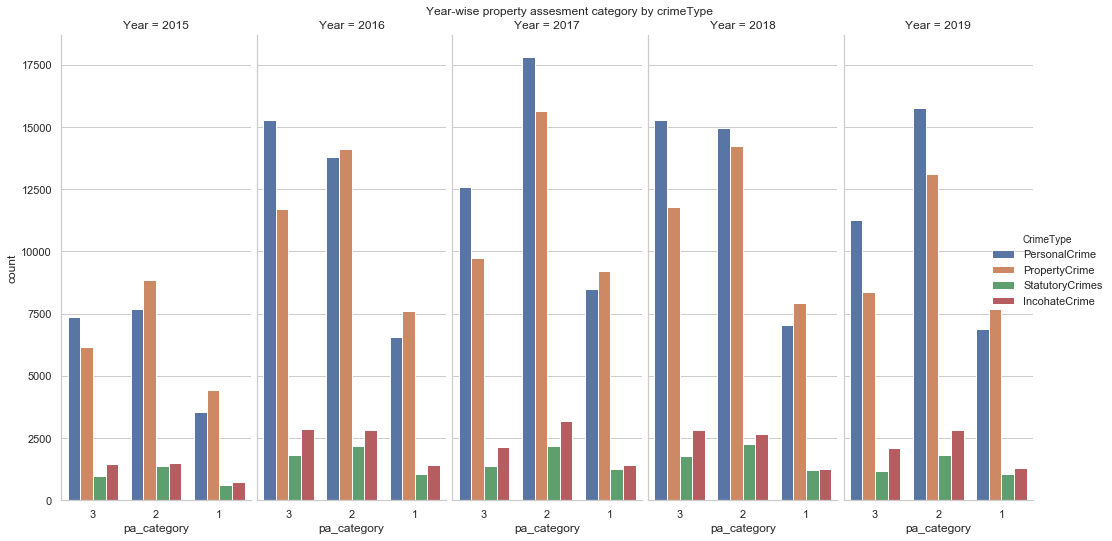

In [97]:
g=sns.catplot(x="pa_category",     
            hue="CrimeType",    
            col="Year",       
            data=crimes_prep_plot_df,
            kind="count")
#Crime rates are consistent in the districts B2, C11 & D4 across the 4 years

g.fig.set_size_inches(15, 8)
g.set_xticklabels(rotation=0)
g.fig.suptitle("Year-wise property assesment category by crimeType ")

In [98]:
streetlights_grp_df.head()

,zipcode,Count,SL_Category
0,02026,32,3
1,02045,8,3
2,02108,1703,2
3,02109,1035,2
4,02110,1347,2


In [99]:
SL_zipcode_map1 = streetlights_grp_df.sort_values(by='Count', ascending=False).reset_index()
SL_zipcode_map1= SL_zipcode_map1.iloc[0:20,]

In [100]:
SL_zipcode_map1

,index,zipcode,Count,SL_Category
0,18,02127,5071,1
1,11,02119,4717,1
2,10,02118,4683,1
3,13,02121,4231,1
4,12,02120,3906,1
5,15,02124,3846,1
6,20,02129,3719,1
7,19,02128,3645,1
8,21,02130,3258,1
9,25,02135,2925,1


Text(0.5, 1.0, 'Lollipop Chart for top 20 Zipcodes with highest count of streetlights ')

Text(0, 0.5, 'Streetlight Counts')

[Text(0, 0, '02127'),
 Text(0, 0, '02119'),
 Text(0, 0, '02118'),
 Text(0, 0, '02121'),
 Text(0, 0, '02120'),
 Text(0, 0, '02124'),
 Text(0, 0, '02129'),
 Text(0, 0, '02128'),
 Text(0, 0, '02130'),
 Text(0, 0, '02135'),
 Text(0, 0, '02126'),
 Text(0, 0, '02111'),
 Text(0, 0, '02115'),
 Text(0, 0, '02199'),
 Text(0, 0, '02122'),
 Text(0, 0, '02131'),
 Text(0, 0, '02132'),
 Text(0, 0, '02210'),
 Text(0, 0, '02113'),
 Text(0, 0, '02108')]

(1500, 5500)

Text(02127, 5071.5, '5071')

Text(02119, 4717.5, '4717')

Text(02118, 4683.5, '4683')

Text(02121, 4231.5, '4231')

Text(02120, 3906.5, '3906')

Text(02124, 3846.5, '3846')

Text(02129, 3719.5, '3719')

Text(02128, 3645.5, '3645')

Text(02130, 3258.5, '3258')

Text(02135, 2925.5, '2925')

Text(02126, 2879.5, '2879')

Text(02111, 2549.5, '2549')

Text(02115, 2529.5, '2529')

Text(02199, 2457.5, '2457')

Text(02122, 2237.5, '2237')

Text(02131, 2212.5, '2212')

Text(02132, 2157.5, '2157')

Text(02210, 2043.5, '2043')

Text(02113, 1912.5, '1912')

Text(02108, 1703.5, '1703')

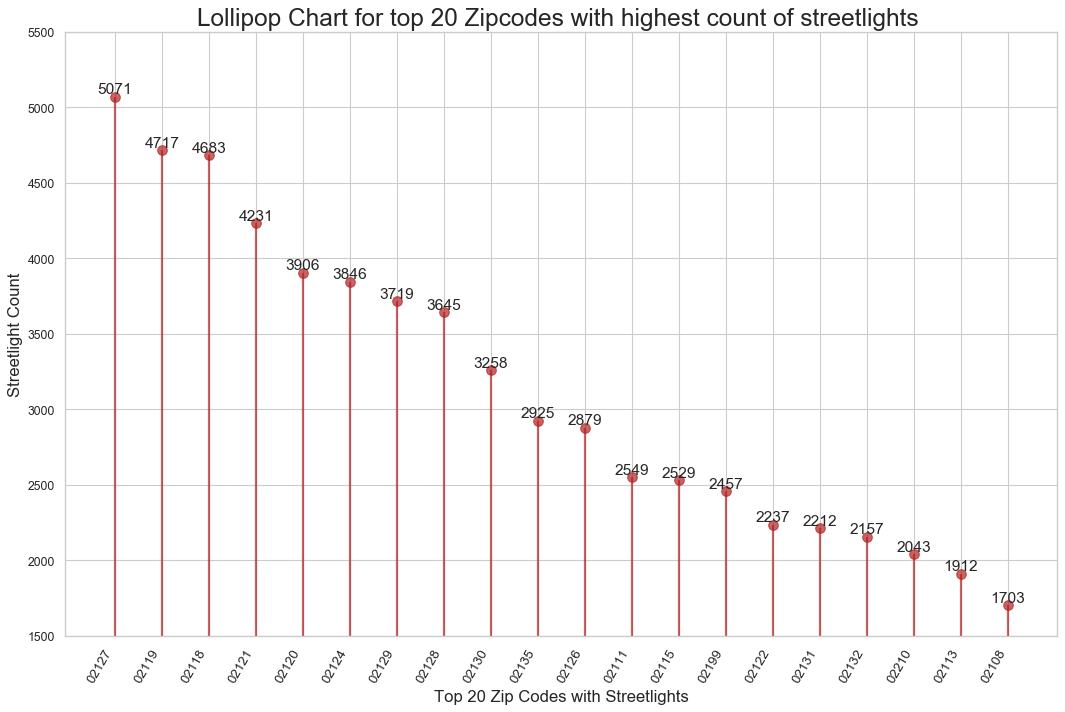

In [101]:
# Draw plot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.vlines(x=SL_zipcode_map1.zipcode, ymin=0, ymax=SL_zipcode_map1.Count, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=SL_zipcode_map1.zipcode, y=SL_zipcode_map1.Count, s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Lollipop Chart for top 20 Zipcodes with highest count of streetlights ', fontdict={'size':22})
ax.set_ylabel('Streetlight Counts')
ax.set_xticks(SL_zipcode_map1.index)
ax.set_xticklabels(SL_zipcode_map1.zipcode, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(1500, 5500)
label = ax.set_xlabel('Top 20 Zip Codes with Streetlights', fontsize = 15)
label = ax.set_ylabel('Streetlight Count', fontsize = 15)
# Annotate
for row in SL_zipcode_map1.itertuples():
    ax.text(row.zipcode, row.Count+.5, s=round(row.Count, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

In [102]:
!pip install folium
import folium

In [103]:

SL_grp_df=streetlights_df.groupby(['zipcode','Lat','Long']).sum()[['Count']].reset_index()

In [104]:
SL_grp_df.shape

(9398, 4)

In [105]:
import folium
from folium.plugins import HeatMap

In [106]:
 
crimes_df = crimes_df.dropna()

In [107]:
heat_map = folium.Map(location=[42.361145,-71.057083],
                    zoom_start = 12, min_zoom=12) #Giving the location just write boston coordinat to google


heat_df = crimes_df[crimes_df['OFFENSE_CODE_GROUP']=='Larceny'] 
heat_df = heat_df[['Lat', 'Long']]  
    
folium.CircleMarker([42.356145,-71.064083],
                    radius=50,
                    popup='Homicide',
                    color='red',
                    ).add_to(heat_map) #Adding mark on the map but it's hard to find correct place. 
                                         #it's take to muhc time
    
    
heat_data = [[row['Lat'],row['Long']] for index, row in heat_df.iterrows()]
#We have to give latitude and longitude like this [[lat, lon],[lat, lon],[lat, lon],[lat, lon],[lat, lon]]

HeatMap(heat_data, radius=10).add_to(heat_map) #Adding map_hooray to HeatMap
heat_map

In [108]:
crimes_prep_df=crimes_prep_df.drop(['Date','Latitude','Longitude','Street'],axis=1)

In [109]:
crimes_prep_df['Area'] = pd.to_numeric(crimes_prep_df['Area'], errors='coerce')
crimes_prep_df['Area']=crimes_prep_df['Area'].fillna(0) 

crimes_prep_df['Day'] = crimes_prep_df['Day'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})

crimes_prep_df['DistrictName'] = crimes_prep_df['DistrictName'].map({'External':1, 'Jamaica Plain':2, 'Hyde Park':3, 'Brighton':4, 'South End':5,'Charlestown':6,
     'Mattapan':7, 'Downtown':8, 'East Boston':9,'West Roxbury':10, 'Roxbury':11, 'Dorchester':12, 'South Boston':13,
     'NotExists':14})

crimes_prep_df.head()

,Area,Shooting,Year,Month,Day,Hour,CrimeType,DistrictName,zip,pa_category,SL_Category
0,574.0,0,2019,11,2,18,PersonalCrime,2,02120,2,1
1,498.0,0,2019,11,6,5,PropertyCrime,3,02124,2,1
2,519.0,0,2019,10,7,9,PropertyCrime,3,02122,3,1
3,493.0,0,2019,10,6,20,PropertyCrime,3,02136,3,2
4,794.0,0,2019,10,6,15,PropertyCrime,4,02124,2,1


In [110]:
crimes_prep_df.isna().sum()

Area            0
Shooting        0
Year            0
Month           0
Day             0
Hour            0
CrimeType       0
DistrictName    0
zip             0
pa_category     0
SL_Category     0
dtype: int64

In [111]:
#excluding the response column CrimeType
crimes_final_df_X = crimes_prep_df.drop(['CrimeType'],axis=1)
crimes_final_df_Y=pd.DataFrame()
crimes_final_df_Y['CrimeType']= crimes_prep_df['CrimeType']

# Change the crimetype as categorical value 1,2,3,4
crimes_final_df_Y['CrimeType'] = crimes_final_df_Y['CrimeType'].map({'PersonalCrime':1, 'PropertyCrime':2, 'StatutoryCrimes':3,
     'IncohateCrime':4})

print(crimes_final_df_Y.shape)

(359737, 1)


In [112]:
X_train,X_test,y_train,y_test=train_test_split(crimes_final_df_X,crimes_final_df_Y, test_size=0.2, random_state=90)

In [113]:
X_train.columns

Index(['Area', 'Shooting', 'Year', 'Month', 'Day', 'Hour', 'DistrictName', 'zip', 'pa_category', 'SL_Category'], dtype='object')

**Applying Normalization

In [114]:
mmscale=MinMaxScaler(feature_range=(0,1))
X_train_norm_df=pd.DataFrame(mmscale.fit_transform(X_train),columns=list(X_train.columns),index=X_train.index)
X_test_norm_df=pd.DataFrame(mmscale.transform(X_test),columns=list(X_test.columns),index=X_test.index)

# LOGISTICREGRESSIONCV MODEL

In [115]:
Cs = 10.0**np.arange(-5,5)
logregCV_mc = LogisticRegressionCV(Cs = Cs,cv=5,solver='lbfgs',multi_class='multinomial') #l1 is Lasso like
logregCV_mc.fit(X_train_norm_df, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [116]:
y_train_pred_multi = logregCV_mc.predict(X_train_norm_df) 

y_test_pred_multi = logregCV_mc.predict(X_test_norm_df)

# accuracy
train_score_multi = accuracy_score(y_train, y_train_pred_multi)
test_score_multi = accuracy_score(y_test,y_test_pred_multi)


print("train accuracy score:",train_score_multi)
print("test accuracy score:",test_score_multi)

train accuracy score: 0.46714780620524066
test accuracy score: 0.46426585867571024


In [117]:
names.append('Merged Data set Logistic Regression w/ CV')
acc_scores.append([train_score_multi, test_score_multi])
df_results = pd.DataFrame(acc_scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_results

,Train Accuracy,Test Accuracy
Logistic Regression w/ CV,0.463836,0.465298
Merged Data set Logistic Regression w/ CV,0.467148,0.464266


In [118]:
y_test_pred_multi = logregCV_mc.predict(X_test_norm_df[:1])
print('\nPredicted class :',y_test_pred_multi)


Predicted class : [1]


In [119]:
# looking at the actual test data from that row
print(X_test[:1])
print('\nActual crime type class :',y_test[:1])

y_test_pred_multi = logregCV_mc.predict_proba(X_test_norm_df[:1])
print('\nPredicted probability for each class :',y_test_pred_multi)

print('\nActual raw incident row\n')
crimes_prep_df.iloc[4580]


        Area Shooting  Year  Month  Day  Hour  DistrictName    zip pa_category SL_Category
70607  262.0        0  2018     11    7    13            11  02119           3           1

Actual crime type class :        CrimeType
70607          1

Predicted probability for each class : [[0.49696868 0.37068139 0.05016831 0.08218162]]

Actual raw incident row



Area                      355
Shooting                    0
Year                     2019
Month                       9
Day                         3
Hour                        6
CrimeType       PersonalCrime
DistrictName               12
zip                     02122
pa_category                 3
SL_Category                 1
Name: 4678, dtype: object

# RANDOM FOREST TREE MODEL

Let’s first fit a random forest with default parameters to get a baseline idea of the performance

In [120]:
rf = RandomForestClassifier()
rf.fit(X_train_norm_df, y_train)
train_pred = rf.predict(X_train_norm_df)

rf_train_score = accuracy_score(y_train,  train_pred)


y_pred = rf.predict(X_test_norm_df)
rf_test_score = accuracy_score(y_test, y_pred)
print("Random forest with default values :Baseline Random Forest")
print("Accuracy, Training Set \t : {:.2%}".format(rf_train_score))
print("Accuracy, Testing Set \t : {:.2%}".format(rf_test_score))
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Random forest with default values :Baseline Random Forest
Accuracy, Training Set 	 : 96.08%
Accuracy, Testing Set 	 : 46.84%


In [121]:
names.append('Merged dataset Baseline Random Forest')
acc_scores.append([rf_train_score, rf_test_score])
df_results = pd.DataFrame(acc_scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_results

,Train Accuracy,Test Accuracy
Logistic Regression w/ CV,0.463836,0.465298
Merged Data set Logistic Regression w/ CV,0.467148,0.464266
Merged dataset Baseline Random Forest,0.960805,0.468449


In [122]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_norm_df, y_train)
    train_pred = rf.predict(X_train_norm_df)
    
    score = accuracy_score(y_train,  train_pred)
    train_results.append(score)
    
    y_pred = rf.predict(X_test_norm_df)
    score = accuracy_score(y_test, y_pred)
    
    test_results.append(score)
    
    


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Text(0, 0.5, 'Accuracy score')

Text(0.5, 0, 'n_estimators')

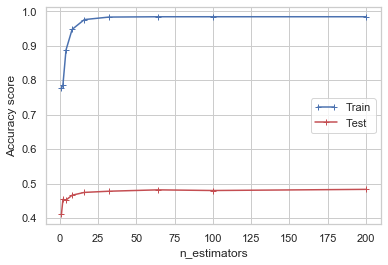

In [123]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b+-', label='Train')
line2, = plt.plot(n_estimators, test_results, 'r+-', label='Test')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')
plt.show()

we can stop at 25 trees as increasing the number of trees decreases the test performance.

The deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 1 to 25 and plot the training and test errors.

In [124]:
max_depths = np.linspace(1, 25, 25, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train_norm_df, y_train)
    train_pred = rf.predict(X_train_norm_df)
    
    score = accuracy_score(y_train,  train_pred)
    train_results.append(score)
    
    y_pred = rf.predict(X_test_norm_df)
    score = accuracy_score(y_test, y_pred)
    
    test_results.append(score)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=13.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=17.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=19.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=21.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=22.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=23.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=24.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25.0, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Text(0, 0.5, 'Accuracy score')

Text(0.5, 0, 'Depth')

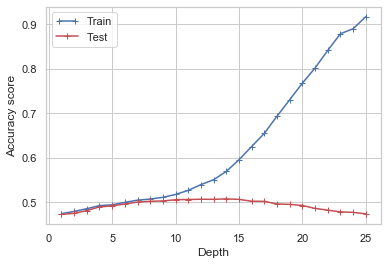

In [125]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b+-', label='Train')
line2, = plt.plot(max_depths, test_results, 'r+-', label='Test')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Depth')
plt.show()

We see that our model overfits for large depth values. The trees perfectly predicts all of the train data,

however,it fails to generalize the findings for new data

In [126]:
rf = RandomForestClassifier(n_estimators=25,max_depth=14)
fitted_rf=rf.fit(X_train_norm_df, y_train)
train_pred = rf.predict(X_train_norm_df)

rf_train_score = accuracy_score(y_train,  train_pred)


y_pred = rf.predict(X_test_norm_df)
rf_test_score = accuracy_score(y_test, y_pred)
print("Random forest with with 25  Trees and Tree depth of 14 :")
print("Accuracy, Training Set \t : {:.2%}".format(rf_train_score))
print("Accuracy, Testing Set \t : {:.2%}".format(rf_test_score))
 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random forest with with 25  Trees and Tree depth of 14 :
Accuracy, Training Set 	 : 57.91%
Accuracy, Testing Set 	 : 50.97%


In [127]:
names.append('Merged dataset best Random Forest (25 Trees, Depth 14)')
acc_scores.append([rf_train_score, rf_test_score])
df_results = pd.DataFrame(acc_scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_results.index.name = 'Model'
df_results

,Train Accuracy,Test Accuracy
Model,,
Logistic Regression w/ CV,0.463836,0.465298
Merged Data set Logistic Regression w/ CV,0.467148,0.464266
Merged dataset Baseline Random Forest,0.960805,0.468449
"Merged dataset best Random Forest (25 Trees, Depth 14)",0.579094,0.509660


<Figure size 720x864 with 0 Axes>

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x1329a586c88>,
 <a list of 10 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

Text(0.5, 1.0, 'Random Forest  - Variable Importance')

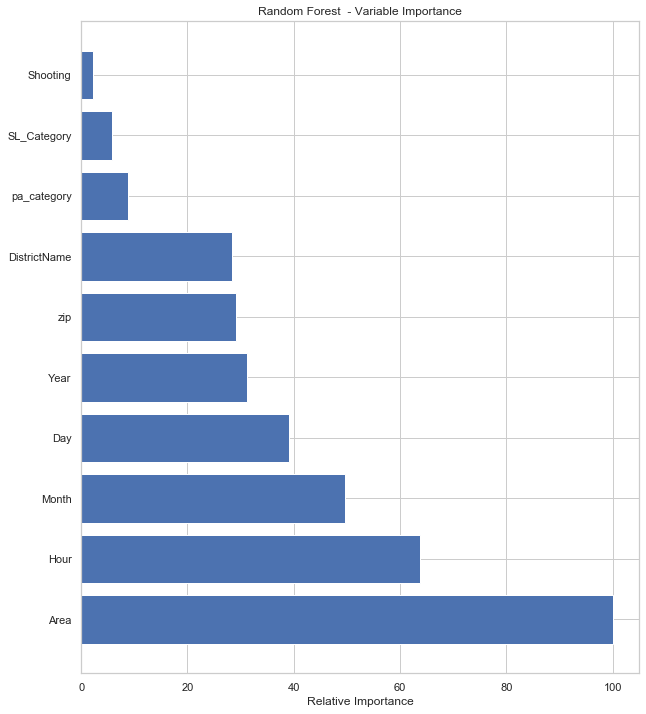

In [128]:
# Plot for Random Forest Model Top Predictors
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(-feature_importance)
sorted_idx = sorted_idx[0:10,]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_norm_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest  - Variable Importance')
plt.show()

# XGBOOST MODEL
  

In [129]:
! pip install xgboost

In [130]:
import xgboost as xgb
best_depth=7
# Create the training and test data
dtrain = xgb.DMatrix(X_train_norm_df, label=y_train)
dtest = xgb.DMatrix(X_test_norm_df, label=y_test)

# Parameters
param = {
    'max_depth': best_depth,  # the maximum depth of each tree
    'eta': 0.3,               # the training step for each iteration
    'silent': 1,              # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 5}           # the number of classes that exist in this datset

# Number of training iterations
num_round = 200  

# Start timer
start = time.time()

# Train XGBoost
bst = xgb.train(param, 
                dtrain, 
                num_round, 
                evals= [(dtrain, 'train')], 
                early_stopping_rounds=20, # early stopping
                verbose_eval=20)


# Make prediction training set
preds_train = bst.predict(dtrain)
best_preds_train = np.asarray([np.argmax(line) for line in preds_train])

# Make prediction test set
preds_test = bst.predict(dtest)
best_preds_test = np.asarray([np.argmax(line) for line in preds_test])

# Performance Evaluation 
acc_XGBoost_training = accuracy_score(y_train, best_preds_train)
acc_XGBoost_test = accuracy_score(y_test, best_preds_test)

# Stop Timer
end = time.time()
elapsed_xgboost = end - start

print("XGBoost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_XGBoost_training))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

[0]	train-merror:0.493417
Will train until train-merror hasn't improved in 20 rounds.
[20]	train-merror:0.476356
[40]	train-merror:0.465344
[60]	train-merror:0.456734
[80]	train-merror:0.449691
[100]	train-merror:0.442758
[120]	train-merror:0.43657
[140]	train-merror:0.430934
[160]	train-merror:0.425114
[180]	train-merror:0.420006
[199]	train-merror:0.416037
XGBoost:	Accuracy, Training Set 	: 0.58%
XGBoost:	Accuracy, Testing Set 	: 0.51%


In [131]:
print("Models training and test summary results:")
names.append('Merged dataset XG Boost')
acc_scores.append([acc_XGBoost_training, acc_XGBoost_test])
df_results = pd.DataFrame(acc_scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_results.index.name = 'Model'
df_results

Models training and test summary results:


,Train Accuracy,Test Accuracy
Model,,
Logistic Regression w/ CV,0.463836,0.465298
Merged Data set Logistic Regression w/ CV,0.467148,0.464266
Merged dataset Baseline Random Forest,0.960805,0.468449
"Merged dataset best Random Forest (25 Trees, Depth 14)",0.579094,0.509660
Merged dataset XG Boost,0.583963,0.511216


Conclusion:

    Based on the 5 models tranining and test accuracy ,we are going to select Merged dataset best Random Forest (25 Trees, Depth 14) and Merged dataset XG Boost model.These two models are providing the best test accuraicies.